In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import collections
import gymnasium as gym
import random
# import rl_utils

In [29]:
## Predefined functions from rl_utils
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

## Carpole Environment
state space: (x, v, ang, tip_v)
action space: (left, right)
minmax bound for state: x in [-2.4 2.4], v in [-Inf, Inf], ang in [-40deg, 40deg], tip_v in [-Inf, Inf]

In [30]:
## Q-net with only one hidden layer
class Q_net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Q_net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [31]:
class DQN:
    '''DQN algorithm implementation'''
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma, epsilon, tgt_update, device):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        # trained Q-network and target Q-network
        self.Q_net = Q_net(state_dim, hidden_dim, action_dim).to(device)
        self.target_Q_net = Q_net(state_dim, hidden_dim, action_dim).to(device)
        # optimizer and hyperparameters
        self.optimizer = torch.optim.Adam(self.Q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.tgt_update = tgt_update # target network update frequency
        self.count = 0 # to count the number of updates
        self.device = device # to specify the device (CPU or GPU)

    # epsilon-greedy action selection
    def action_selection(self, state):
        # table version
        # if np.random.rand() < self.epsilon:
        #     action = np.random.choice(self.n_action)
        # else:
        #     action = np.argmax(self.Q_table[state])
        # return action

        # functional version
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float).to(self.device)
            q_values = self.Q_net(state_tensor)
            action = torch.argmax(q_values).item()
        
        return action
    
    def DQN_main(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        q_vals = self.Q_net(states).gather(1, actions)
        # max Q-value of next states
        with torch.no_grad():
            max_next_q_vals = self.target_Q_net(next_states).max(1)[0].view(-1, 1)
        # calculate target Q-values (TD error target)
        q_target = rewards + self.gamma * max_next_q_vals * (1 - dones)
        dqn_loss = F.mse_loss(q_vals, q_target, reduction='mean')
        # optimizer
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        # update target Q-network
        if self.count % self.tgt_update == 0:
            self.target_Q_net.load_state_dict(self.Q_net.state_dict())
        self.count += 1

In [32]:
class DDQN:
    '''DDQN algorithm implementation'''
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma, epsilon, tgt_update, device):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        # trained Q-network and target Q-network
        self.Q_net = Q_net(state_dim, hidden_dim, action_dim).to(device)
        self.target_Q_net = Q_net(state_dim, hidden_dim, action_dim).to(device)
        # optimizer and hyperparameters
        self.optimizer = torch.optim.Adam(self.Q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.tgt_update = tgt_update # target network update frequency
        self.count = 0 # to count the number of updates
        self.device = device # to specify the device (CPU or GPU)

    # epsilon-greedy action selection
    def action_selection(self, state):
        # table version
        # if np.random.rand() < self.epsilon:
        #     action = np.random.choice(self.n_action)
        # else:
        #     action = np.argmax(self.Q_table[state])
        # return action

        # functional version
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float).to(self.device)
            q_values = self.Q_net(state_tensor)
            action = torch.argmax(q_values).item()
        return action
    
    def DDQN_main(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        q_vals = self.Q_net(states).gather(1, actions)
        # max Q-value of next states
        # two steps in DDQN: 1. argmax_{a'}Q_net(s', a'); 2. Q_target(s, argmax_{a'}Q_net(s', a')), 
        # two networks are used to decouple the action selection and Q-value estimation
        # in DQN, we only use Q_target(s', a') to calculate the target Q-value
        with torch.no_grad():
            max_action = torch.argmax(self.Q_net(next_states), dim=1, keepdim=True)
            max_next_q_vals = self.target_Q_net(next_states).gather(1, max_action)
        # calculate target Q-values (TD error target)
        q_target = rewards + self.gamma * max_next_q_vals * (1 - dones)
        dqn_loss = F.mse_loss(q_vals, q_target, reduction='mean')
        # optimizer
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        # update target Q-network
        if self.count % self.tgt_update == 0:
            self.target_Q_net.load_state_dict(self.Q_net.state_dict())
        self.count += 1

In [33]:
## Main program

# seems to diverge in the long run, maybe an adaptive learning rate is needed
# e.g. sum(a_t)=\infty, sum(a_t^2)<\infty
lr = 1e-3  # learning rate
hidden_dim = 80
gamma = 0.98 # discount factor
epsilon = 0.05 # exploration rate
num_episodes = 300 # number of episodes to train
tgt_update = 10 # target network update frequency
buffer_size = 10000 # replay buffer size
minimal_size = 500 # minimal size of replay buffer to start training
batch_size = 100 # batch size for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1') # create the environment

# C.I.A.L.L.O. random seed
env.action_space.seed(0)
random.seed(7)
np.random.seed(2)
torch.manual_seed(1)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0] # default dim = 4, position, velocity, angle, angular velocity
action_dim = env.action_space.n # default dim = 2 (Bang-Bang control), can be changed to 3 or more
agent = DDQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, tgt_update, device)

return_list = []
for i in range(10):
    for i_ep in range(int(num_episodes/10)):
        episode_return = 0
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.action_selection(state)
            next_state, reward, done, _, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward
            
            if replay_buffer.size() >= minimal_size:
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {'states': b_s, 'actions': b_a,
                                   'rewards': b_r, 'next_states': b_ns, 'dones': b_d}
                agent.DDQN_main(transition_dict)
        # record return
        return_list.append(episode_return)
        if (i_ep + 1) % 10 == 0:
            print(f'Episode {i * int(num_episodes/10) + i_ep + 1}, Return: {episode_return}')
               


Episode 10, Return: 13.0
Episode 20, Return: 18.0
Episode 30, Return: 15.0
Episode 40, Return: 10.0
Episode 50, Return: 10.0
Episode 60, Return: 9.0
Episode 70, Return: 11.0
Episode 80, Return: 13.0
Episode 90, Return: 8.0
Episode 100, Return: 40.0
Episode 110, Return: 62.0
Episode 120, Return: 74.0
Episode 130, Return: 82.0
Episode 140, Return: 238.0
Episode 150, Return: 197.0
Episode 160, Return: 181.0
Episode 170, Return: 186.0
Episode 180, Return: 156.0
Episode 190, Return: 158.0
Episode 200, Return: 207.0
Episode 210, Return: 185.0
Episode 220, Return: 212.0
Episode 230, Return: 242.0
Episode 240, Return: 232.0
Episode 250, Return: 124.0
Episode 260, Return: 285.0
Episode 270, Return: 174.0
Episode 280, Return: 511.0
Episode 290, Return: 310.0
Episode 300, Return: 25.0


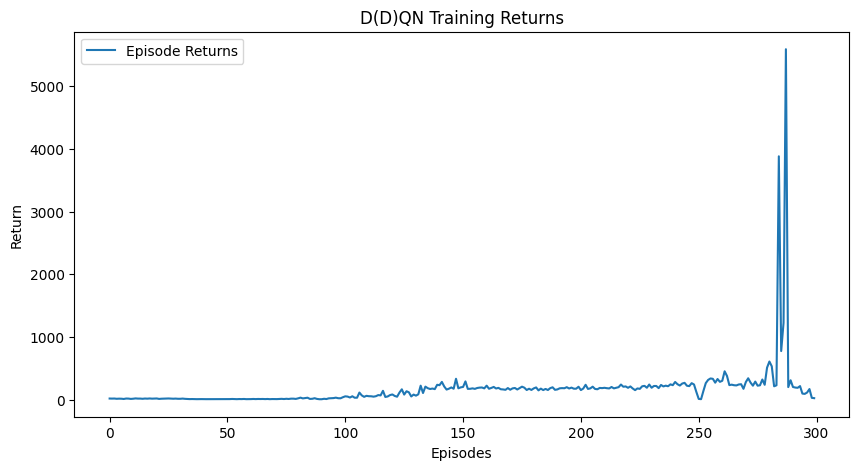

In [34]:
## Plotting the results
episodes_list = list(range(len(return_list)))
plt.figure(figsize=(10, 5))
plt.plot(episodes_list, return_list, label='Episode Returns')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('D(D)QN Training Returns')
plt.legend()

# move average return list to be added

In [9]:
class P_net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(P_net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=0) # "dim=1" to be detailed, may be related to action space

In [24]:
## REINFORCE algorithm (Primitive MC + Policy Gradient)
class REINFORCE:
    ''' REINFORCE algorithm implementation '''
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma, device):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        # policy network
        self.P_net = P_net(state_dim, hidden_dim, action_dim).to(device)
        # optimizer and hyperparameters
        self.optimizer = torch.optim.Adam(self.P_net.parameters(), lr=lr)
        self.gamma = gamma
        self.device = device
        
    def action_selection(self, state): # random sampling according to the policy probabilities distribution
        state_tensor = torch.tensor(state, dtype=torch.float).to(self.device)
        prob_policy = self.P_net(state_tensor)
        dist = torch.distributions.Categorical(prob_policy)
        action = dist.sample().item()
        return action
    
    def REINFORCE_main(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        
        G = 0
        self.optimizer.zero_grad()
        # Estimate G
        # generate an eposiode and calculate the return G
        for i in reversed(range(len(rewards))):
            reward = rewards[i]
            state = states[i]
            action = actions[i]
            prob_mid = self.P_net(state)
            ln_prob = torch.log(prob_mid[action])
            G = reward + self.gamma * G
            loss = -ln_prob * G
            loss.backward() # theta = theta + alpha*gamma^?*G*grad_ln(pi(a|s, theta))   
        # optimizer
        self.optimizer.step()
        
        

In [25]:
## REINFORCE main program
lr = 2e-3  # learning rate
hidden_dim = 100
gamma = 0.98 # discount factor
# epsilon = 0.05 # exploration rate
num_episodes = 500 # number of episodes to train
# buffer_size = 10000 # replay buffer size
# minimal_size = 500 # minimal size of replay buffer to start training
# batch_size = 100 # batch size for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1') # create the environment

# C.I.A.L.L.O. random seed
env.action_space.seed(0)
random.seed(7)
np.random.seed(2)
torch.manual_seed(1)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0] # default dim = 4, position, velocity, angle, angular velocity
action_dim = env.action_space.n # default dim = 2 (Bang-Bang control), can be changed to 3 or more
agent = REINFORCE(state_dim, hidden_dim, action_dim, lr, gamma, device)

return_list = []
for i in range(10):
    for i_ep in range(int(num_episodes/10)):
        # reset the environment and transition dictionary
        episode_return = 0
        state, _ = env.reset()
        done = False
        transition_dict = {'states': [], 'actions': [], 'rewards': [], 'next_states': [], 'dones': []}
        # simulate an entire episode
        while not done:
            # step forward
            action = agent.action_selection(state)
            next_state, reward, done, _, _ = env.step(action)
            # store the transition in the transition dictionary
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['rewards'].append(reward)
            transition_dict['next_states'].append(next_state)
            transition_dict['dones'].append(done)
            state = next_state # update state
            episode_return += reward # record the return
        # After the episode ends, we use the G obtained from the episode to update the policy network
        return_list.append(episode_return)
        agent.REINFORCE_main(transition_dict)
        # print the return every 10 episodes
        if (i_ep + 1) % 10 == 0:
            print(f'Episode {i * int(num_episodes/10) + i_ep + 1}, Return: {episode_return}')

Episode 10, Return: 16.0
Episode 20, Return: 32.0
Episode 30, Return: 40.0
Episode 40, Return: 10.0
Episode 50, Return: 82.0
Episode 60, Return: 61.0
Episode 70, Return: 44.0
Episode 80, Return: 16.0
Episode 90, Return: 23.0
Episode 100, Return: 14.0
Episode 110, Return: 74.0
Episode 120, Return: 159.0
Episode 130, Return: 129.0
Episode 140, Return: 183.0
Episode 150, Return: 230.0
Episode 160, Return: 140.0
Episode 170, Return: 125.0
Episode 180, Return: 309.0
Episode 190, Return: 185.0
Episode 200, Return: 296.0
Episode 210, Return: 321.0
Episode 220, Return: 526.0
Episode 230, Return: 369.0
Episode 240, Return: 941.0
Episode 250, Return: 185.0
Episode 260, Return: 163.0
Episode 270, Return: 216.0
Episode 280, Return: 397.0
Episode 290, Return: 412.0
Episode 300, Return: 672.0
Episode 310, Return: 525.0
Episode 320, Return: 238.0
Episode 330, Return: 138.0
Episode 340, Return: 123.0
Episode 350, Return: 105.0
Episode 360, Return: 138.0
Episode 370, Return: 140.0
Episode 380, Return: 

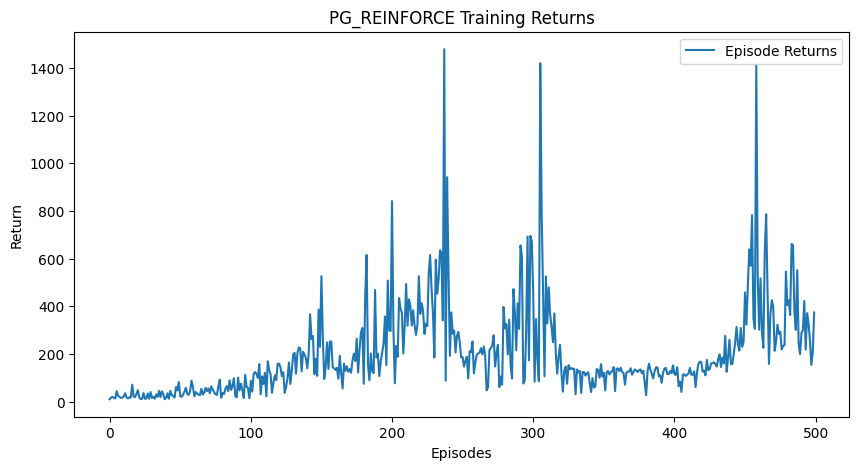

In [26]:
## Plotting the results
episodes_list = list(range(len(return_list)))
plt.figure(figsize=(10, 5))
plt.plot(episodes_list, return_list, label='Episode Returns')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('PG_REINFORCE Training Returns')
plt.legend()

# move average return list to be added